# Neural Network Class

SURAJ ESWARAN

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Class" data-toc-modified-id="Neural-Network-Class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Class</a></span></li><li><span><a href="#QSAR-aquatic-toxicity-Data-Set" data-toc-modified-id="QSAR-aquatic-toxicity-Data-Set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>QSAR aquatic toxicity Data Set</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Check-In" data-toc-modified-id="Check-In-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check-In</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>



* A3.3: *Modified `A3grader.tar` to correctly grade the `error_trace` value.  It now assumes you use the following function for the `error_convert_f`:

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)

* A3.2: *Added `A3grader.py` and additional requirements involving application of your `NeuralNetwork` class to a specific data set.*
* A3.1: *Added some details on specifications of required functions and many examples of running your implementation.*

You will define a new class named `NeuralNetwork` that constructs a neural network with any number of hidden layers.  To train the neural network, you will use our `optimizers.py` code. Use this updated version: [optimizers.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar).  Your class must implement at least the following functions. Lecture Notes 07 provide examples of some of the code in the section about using `Optimizers` on which you can base your implementation.

* `__init__(self, n_inputs, n_hiddens_list, n_outputs)`: 
* `__repr__(self):`
* `make_weights(self):` called from constructor `__init__`
* `initialize_weights(self):` called from constructor `__init__`
* `train(self, X, T, n_epochs, learning_rate, method='adam', verbose=True):` `method` can be 'sgd', 'adam', or 'scg'. Must first calculate standarization parameters, stored in `stand_params` dictionary, and standardize `X` and `T`.  Import `optimizers.py` and use these optimizers in this `train` function. Use the `tanh` activation function.
* `use(self, X, return_hidden_layer_outputs=False):` standardizes X then calculates the output of the network by calling `forward` and unstandardizing the network output. Returns just the output of the last layer. If `return_hidden_layer_outputs` is `True`, return two things, the output of the last layer and a list of outputs from each hidden layer.
* `get_error_trace(self):` just returns the `error_trace`

Here are some example uses of your `NeuralNetwork` class.  Your implementation should return very close to the same values in each code cell.

## Import Code Needed In This Notebook

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt

## Network Class

In [253]:
class NeuralNetworks():
    def __init__(self,n_input,n_hidden_list,n_output):
        self.n_inputs = n_input
        self.n_hiddens_list = n_hidden_list 
        self.n_outputs=n_output
        self.make_weights()
        self.n_layers=len(n_hidden_list)
        self.initialize_weights()
        self.error_trace = None
        
    def make_gradient(self):
        return self.make_weights()  

    def __ref__(self):
        return f'NeuralNetworks(n_inputs={self.n_inputs}, n_hiddens_list={self.n_hiddens_list}, n_outputs={self.n_outputs})'
    
    def make_weights(self): 
        N=0
        self.Ws=[] #Weights
        self.Gs=[] #Gradients
        
        N=(self.n_inputs+1)*self.n_hiddens_list[0] + (self.n_hiddens_list[-1]+1)*self.n_outputs #Input to First hidden layer
        if (len(self.n_hiddens_list)>1):
            for i in range(0,len(self.n_hiddens_list)-1):
                N= N+(self.n_hiddens_list[i]+1)*self.n_hiddens_list[i+1] #First hidden layer to final hidden layer
        
        self.all_weights = np.zeros(N)
        self.all_gradients = np.zeros(N)
    
        M=(self.n_inputs+1)*self.n_hiddens_list[0] 
        
        
        w_t = self.all_weights[0:M].reshape(self.n_inputs+1, self.n_hiddens_list[0])     
        self.Ws.append(w_t)
        
        g_t = self.all_gradients[0:M].reshape(self.n_inputs+1, self.n_hiddens_list[0])    
        self.Gs.append(g_t)
        
        for j in range(0,len(self.n_hiddens_list)-1):
            w_t = self.all_weights[M:M+((self.n_hiddens_list[j]+1)* self.n_hiddens_list[j+1]) ].reshape(self.n_hiddens_list[j]+1, self.n_hiddens_list[j+1])  #Final hidden layer to output layer
            g_t = self.all_gradients[M:M+((self.n_hiddens_list[j]+1)* self.n_hiddens_list[j+1]) ].reshape(self.n_hiddens_list[j]+1, self.n_hiddens_list[j+1])
            M= M+((self.n_hiddens_list[j]+1)* self.n_hiddens_list[j+1])
            
            self.Ws.append(w_t)
            self.Gs.append(g_t)
   
        w_t = self.all_weights[M:].reshape(self.n_hiddens_list[-1]+1, self.n_outputs) 
        g_t = self.all_gradients[M:].reshape(self.n_hiddens_list[-1]+1, self.n_outputs)   
        
        self.Ws.append(w_t)
        self.Gs.append(g_t)
        
    
    def initialize_weights(self): 
        W = self.Ws[0] #Initialize weights
        W[:] = np.random.uniform(-1, 1, size=((self.n_inputs+1),self.n_hiddens_list[0] )) / np.sqrt(self.n_inputs + 1)
        for k in range(1,len(self.n_hiddens_list)):
            W = self.Ws[k]
            W[:] = np.random.uniform(-1, 1, size=(1 + self.n_hiddens_list[k-1], self.n_hiddens_list[k])) / np.sqrt(self.n_hiddens_list[k-1] + 1)
        W = self.Ws[-1]
        W[:] = np.random.uniform(-1, 1, size=(1 + self.n_hiddens_list[-1], self.n_outputs)) / np.sqrt(self.n_hiddens_list[-1] + 1)    
    
    def add_ones(self,X):
        return np.insert(X, 0, 1, axis=1)
 
    def forward(self,Xst):
        Zs=[] 
        for i in self.Ws[:-1]:
            Z=np.tanh(self.add_ones(Xst) @ i)
            Zs.append(Z)
            Xst = Z
        self.Yst = self.add_ones(Z) @ self.Ws[-1]
        Zs.append(self.Yst)
        return Zs
       
    def backward(self, Xst, Tst):                                   
        self.Zy=[] #Z vector
        global gradient_V, gradient_W                          
        n_samples = Xst.shape[0]
        n_outputs = Tst.shape[1]
        grad_VW=[]
        # Calculate the outputs of both layers.
        self.Zy = self.forward(Xst)                           
        # Calculate the delta value for the output layer. Divide by n_samples * n_outputs
        # because we are calculating the gradient of the mean sqauared error with respect to weights.
        delta = -(Tst - self.Zy[-1]) /  (n_samples * n_outputs)
        for i in range(len(self.Zy)-2,-1,-1):  #Within the range of index - 2
            grad_VW.append(self.add_ones(self.Zy[i]).T @ delta)
            delta = (delta @ self.Ws[i+1][1:, :].T) * (1 - self.Zy[i] ** 2)
            if i==0:
                grad_VW.append(self.add_ones(Xst).T @ delta)
        grad_VW.reverse() #Reversing the gradients
        for j in range(0,len(self.Gs)):
            self.Gs[j][:]=grad_VW[j]*2 #changed here *2
        return self.all_gradients

    def mse(self,Xst,Tst):
        self.Yst = self.forward(Xst)[-1]  #changed
        return np.mean((Tst - self.Yst)**2)
    
    def error_convert(self, err):
        if self.T.shape[1] == 1:
            return np.sqrt(err) * self.stand_params['Tstds']
        else:  
            return np.sqrt(err)
        
    def train(self,X,T,n_epochs,learning_rate,method,verbose=True):
        self.stand_params = self.calc_standardize_parameters(X,T)
        self.T=T
        Xst = self.standardize_X(X, self.stand_params)
        Tst = self.standardize_T(T, self.stand_params)
        
        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        if method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        if method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
          
        self.error_trace = optimizer(self.mse, self.backward,[Xst, Tst], n_epochs, learning_rate,error_convert_f=self.error_convert)
        return self.stand_params, self.error_trace
    
    def use(self, X, return_hidden_layer_outputs=False):
        self.Xst = self.standardize_X(X, self.stand_params)
        # Calculate outputs of each layer.
        self.Zs = self.forward(self.Xst)
        self.Yst=self.Zs.pop()
        self.Yst=self.unstandardize_T(self.Yst, self.stand_params)
        return (self.Yst, self.Zs) if return_hidden_layer_outputs else self.Yst
        # Unstandardize output of output layer

    def get_error_trace(self):
        return self.error_trace
    
    def calc_standardize_parameters(self, X, T):
        self.Xmeans = X.mean(axis=0)
        self.Xstds = X.std(axis=0)
        self.Tmeans = T.mean(axis=0)
        self.Tstds = T.std(axis=0)
        return {'Xmeans': self.Xmeans, 'Xstds': self.Xstds,'Tmeans': self.Tmeans, 'Tstds': self.Tstds}
    
    def standardize_X(self, X, stand_params):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst, stand_params):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T, stand_params):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst, stand_params):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']
    
    #def mse(self,w, n_inputs, n_hiddens_list, n_outputs, X, T):
        #Y =  network(w, n_inputs, n_hiddens_list, n_outputs, X)
        #return np.mean((T - Y)**2) 

## Neural Network Class Verification

In [254]:
np.random.seed(123)
nnet = NeuralNetworks(1, [3], 2)  # 2 outputs
nnet

## all_weights Verification

In [255]:
nnet.all_weights

array([ 0.27784939, -0.30244465, -0.38629038,  0.07257004,  0.31037599,
       -0.10874389,  0.4807642 ,  0.18482974, -0.0190681 , -0.10788248,
       -0.15682198,  0.22904971, -0.06142776, -0.4403221 ])

## Ws Verification 

In [256]:
nnet.Ws

[array([[ 0.27784939, -0.30244465, -0.38629038],
        [ 0.07257004,  0.31037599, -0.10874389]]),
 array([[ 0.4807642 ,  0.18482974],
        [-0.0190681 , -0.10788248],
        [-0.15682198,  0.22904971],
        [-0.06142776, -0.4403221 ]])]

## all_gradients Verification

In [257]:
nnet.all_gradients

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Gs Verification

In [258]:
nnet.Gs

[array([[0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

## Returning evenly spaced numbers over a specified interval

In [259]:
X = np.linspace(-1, 1, 4).reshape(-1, 1)
X

array([[-1.        ],
       [-0.33333333],
       [ 0.33333333],
       [ 1.        ]])

## Stack arrays in sequence horizontally 

In [260]:
T = np.hstack((X ** 2, (X - 2) ** 3))
T

array([[  1.        , -27.        ],
       [  0.11111111, -12.7037037 ],
       [  0.11111111,  -4.62962963],
       [  1.        ,  -1.        ]])

## Training using adam

In [261]:
nnet.train(X, T, 5, 0.01, 'adam')

Adam: Epoch 1 Error=1.04625
Adam: Epoch 2 Error=1.03472
Adam: Epoch 3 Error=1.02343
Adam: Epoch 4 Error=1.01223
Adam: Epoch 5 Error=1.00111


({'Xmeans': array([-5.55111512e-17]),
  'Xstds': array([0.74535599]),
  'Tmeans': array([  0.55555556, -11.33333333]),
  'Tstds': array([0.44444444, 9.98799004])},
 [1.046252745686667,
  1.0347196138595187,
  1.0234280115224064,
  1.0122313682158668,
  1.0011130457971062])

## Stand_Params Verification

In [262]:
nnet.stand_params

{'Xmeans': array([-5.55111512e-17]),
 'Xstds': array([0.74535599]),
 'Tmeans': array([  0.55555556, -11.33333333]),
 'Tstds': array([0.44444444, 9.98799004])}

## Ws Verification

In [263]:
nnet.Ws

[array([[ 0.32805609, -0.25283707, -0.33680913],
        [ 0.02237977,  0.36049589, -0.15868899]]),
 array([[ 0.43097923,  0.13534218],
        [-0.06903616, -0.15739471],
        [-0.10716161,  0.27902101],
        [-0.01180826, -0.44858975]])]

## Error_Trace Verification 

In [264]:
nnet.get_error_trace()

[1.046252745686667,
 1.0347196138595187,
 1.0234280115224064,
 1.0122313682158668,
 1.0011130457971062]

## USE FUNCTION VERIFICATION

In [265]:
nnet.use(X)

array([[  0.76872931, -11.63174677],
       [  0.75768845, -10.3937065 ],
       [  0.74348724,  -9.01615633],
       [  0.72838516,  -7.64787959]])

In [266]:
Y, Zs = nnet.use(X, return_hidden_layer_outputs=True)
Zs # Zs is list of hidden layer output matrices

[array([[ 0.2895092 , -0.62702167, -0.12327529],
        [ 0.30774044, -0.39191092, -0.25975089],
        [ 0.32574848, -0.09136292, -0.38658353],
        [ 0.34352322,  0.22680528, -0.50030489]])]

## Training NeuralNetwork using particular method for n_epochs and learning rate 

In [267]:
def run(method, n_epochs, learning_rate=0):
    
    n_samples = 30
    Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
    Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
    Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    n_inputs = Xtrain.shape[1]
    n_hiddens_list = [50, 20, 20]
    n_outputs = Ttrain.shape[1]

    nnet = NeuralNetworks(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    plt.figure(1, figsize=(10, 10))
    plt.clf()

    n_plot_rows = nnet.n_layers + 1
    ploti = 0

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(nnet.get_error_trace())
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
    plt.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
    plt.plot(X_for_plot, Y, label='Neural Net Output')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')

    for layeri in range(nnet.n_layers - 2, -1, -1):
        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(X_for_plot, Zs[layeri])
        plt.xlabel('X')
        plt.ylabel(f'Outputs from Layer {layeri}')
        
    return nnet

## Training using sgd

sgd: Epoch 400 Error=0.22829
sgd: Epoch 800 Error=0.18081
sgd: Epoch 1200 Error=0.14822
sgd: Epoch 1600 Error=0.13567
sgd: Epoch 2000 Error=0.13215
sgd: Epoch 2400 Error=0.13068
sgd: Epoch 2800 Error=0.12974
sgd: Epoch 3200 Error=0.12911
sgd: Epoch 3600 Error=0.12876
sgd: Epoch 4000 Error=0.12851
Method: sgd, RMSE: Train 0.13 Test 0.29


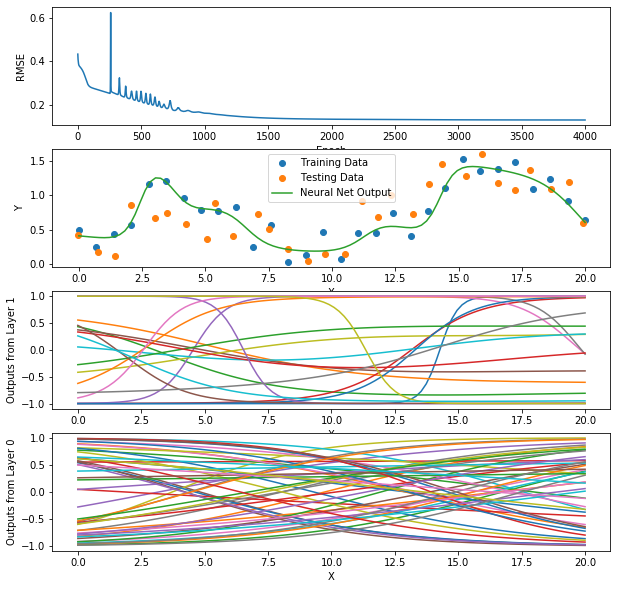

In [268]:
run('sgd', 4000, 0.1)

## Training using adam

Adam: Epoch 200 Error=0.18749
Adam: Epoch 400 Error=0.12221
Adam: Epoch 600 Error=0.09956
Adam: Epoch 800 Error=0.08557
Adam: Epoch 1000 Error=0.08227
Adam: Epoch 1200 Error=0.08200
Adam: Epoch 1400 Error=0.08559
Adam: Epoch 1600 Error=0.07989
Adam: Epoch 1800 Error=0.07668
Adam: Epoch 2000 Error=0.07465
Method: adam, RMSE: Train 0.07 Test 0.26


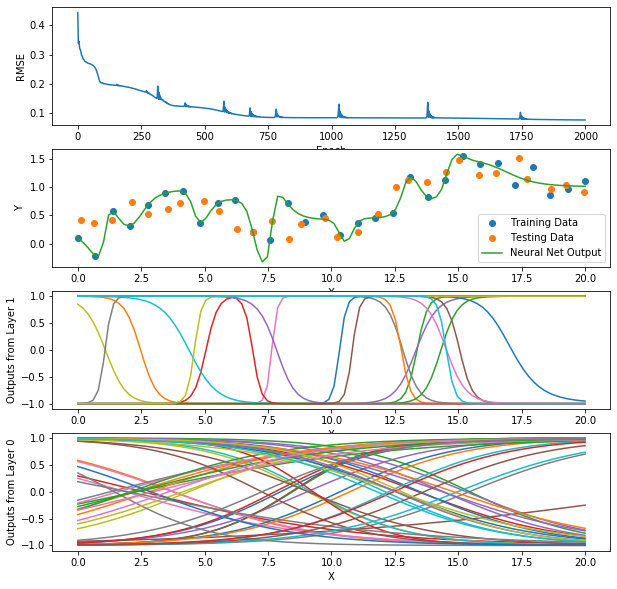

In [269]:
run('adam', 2000, 0.01)

## Training using scg

SCG: Epoch 199 Error=0.14623
SCG: Epoch 399 Error=0.08949
SCG: Epoch 599 Error=0.06921
SCG: Epoch 799 Error=0.05943
SCG: Epoch 999 Error=0.01971
SCG: Epoch 1199 Error=0.00875
SCG: Epoch 1399 Error=0.00049
SCG: Epoch 1599 Error=0.00021
SCG: Epoch 1799 Error=0.00008
SCG: Epoch 1999 Error=0.00002
Method: scg, RMSE: Train 0.00 Test 0.32


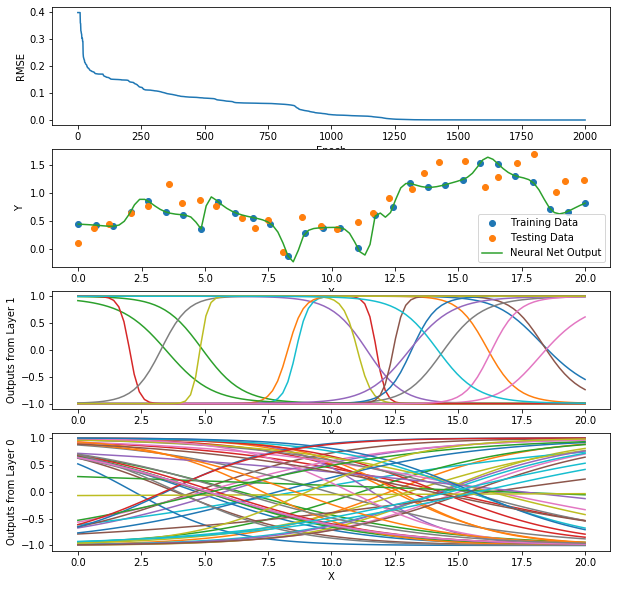

In [270]:
run('scg', 2000)

## RESULT AND DISCUSSION

#  QSAR aquatic toxicity Data Set

Download the QSAR data set from [this UCI ML Repository site](https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity). It consists of eight measurements of water quality that may affect a ninth measurement, of aquatic toxicity towards [Daphnia Magna](https://en.wikipedia.org/wiki/Daphnia_magna#:~:text=Daphnia%20magna%20is%20a%20small,Northern%20Hemisphere%20and%20South%20Africa.).

Your job is to
* read this data into a numpy array,
* randomly shuffle the order of the rows in this data array (`np.random.shuffle`)
* take the first 500 rows as training data and the remaining rows as testing data,
* assign the first eight columns to `Xtrain` and `Xtest`, and the last column to `Ttrain` and `Ttest`,
* do some experimentation with different values of `n_hiddens_list`, `n_epochs` and `learning_rate` for the `sgd` and `adam` methods, and with different values of `n_hiddens_list`, `n_epochs` for `scg`, which does not use the `learning_rate`.
* using the parameter values (`n_hiddens_list`, `n_epochs` and `learning_rate`) that you find produce the lowest RMSE on test data for each method, create plots for each method that include the `error_trace`, the training data targets and predictions by the neural network, and the testing data targets and predictions by the neural network. The differrent methods may use different parameter values.

Describe your results with at least 10 sentences.

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [175]:
datadf = pd.read_csv('qsar_aquatic_toxicity.csv', delimiter=';', header=None)
datadf

0       1  2      3      4      5  6  7      8
0     0.00   0.000  0  2.419  1.225  0.667  0  0  3.740
1     0.00   0.000  0  2.638  1.401  0.632  0  0  4.330
2     9.23  11.000  0  5.799  2.930  0.486  0  0  7.019
3     9.23  11.000  0  5.453  2.887  0.495  0  0  6.723
4     9.23  11.000  0  4.068  2.758  0.695  0  0  5.979
..     ...     ... ..    ...    ...    ... .. ..    ...
541  24.06  35.776  2  3.326  2.837  0.849  2  0  4.651
542   9.23  11.000  0  3.275  2.727  0.874  0  0  3.953
543   0.00   0.000  0  5.165  3.111  0.732  0  0  6.219
544  13.14   9.507  0  2.859  2.614  0.827  0  0  4.995
545   0.00   0.000  0  2.255  1.800  0.917  0  0  2.480

[546 rows x 9 columns]

In [4]:
names = ('TPSA', 'SAacc', 'H-050', 'MLOGP', 'RDCHI', 'GATS1p', 'nN', 'C-40', 'LC50')
datadf.columns = names
datadf

TPSA   SAacc  H-050  MLOGP  RDCHI  GATS1p  nN  C-40   LC50
0     0.00   0.000      0  2.419  1.225   0.667   0     0  3.740
1     0.00   0.000      0  2.638  1.401   0.632   0     0  4.330
2     9.23  11.000      0  5.799  2.930   0.486   0     0  7.019
3     9.23  11.000      0  5.453  2.887   0.495   0     0  6.723
4     9.23  11.000      0  4.068  2.758   0.695   0     0  5.979
..     ...     ...    ...    ...    ...     ...  ..   ...    ...
541  24.06  35.776      2  3.326  2.837   0.849   2     0  4.651
542   9.23  11.000      0  3.275  2.727   0.874   0     0  3.953
543   0.00   0.000      0  5.165  3.111   0.732   0     0  6.219
544  13.14   9.507      0  2.859  2.614   0.827   0     0  4.995
545   0.00   0.000      0  2.255  1.800   0.917   0     0  2.480

[546 rows x 9 columns]

In [5]:
data = datadf.values
data

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  3.74 ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  4.33 ],
       [ 9.23 , 11.   ,  0.   , ...,  0.   ,  0.   ,  7.019],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  6.219],
       [13.14 ,  9.507,  0.   , ...,  0.   ,  0.   ,  4.995],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  2.48 ]])

In [6]:
data = np.loadtxt('qsar_aquatic_toxicity.csv', delimiter=';')
data

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  3.74 ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  4.33 ],
       [ 9.23 , 11.   ,  0.   , ...,  0.   ,  0.   ,  7.019],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  6.219],
       [13.14 ,  9.507,  0.   , ...,  0.   ,  0.   ,  4.995],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  2.48 ]])

In [7]:
data.shape

(546, 9)

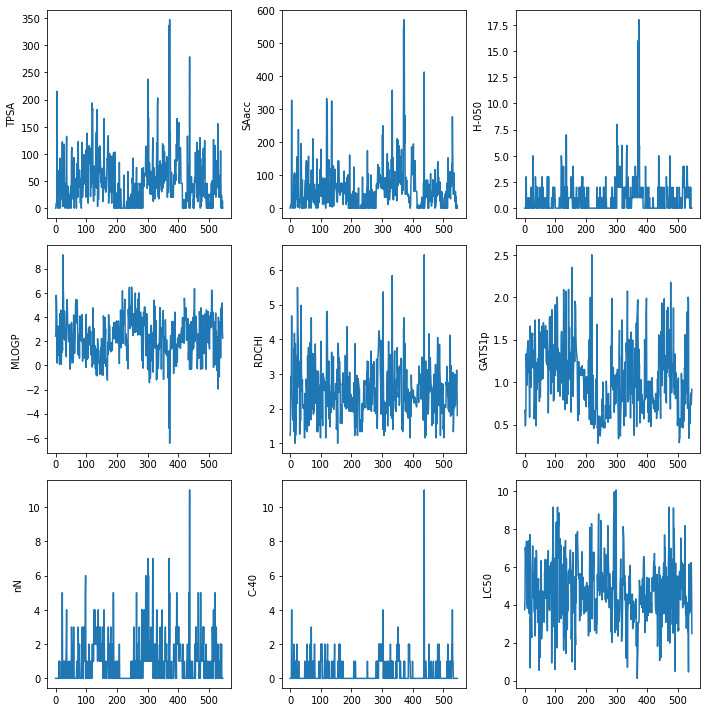

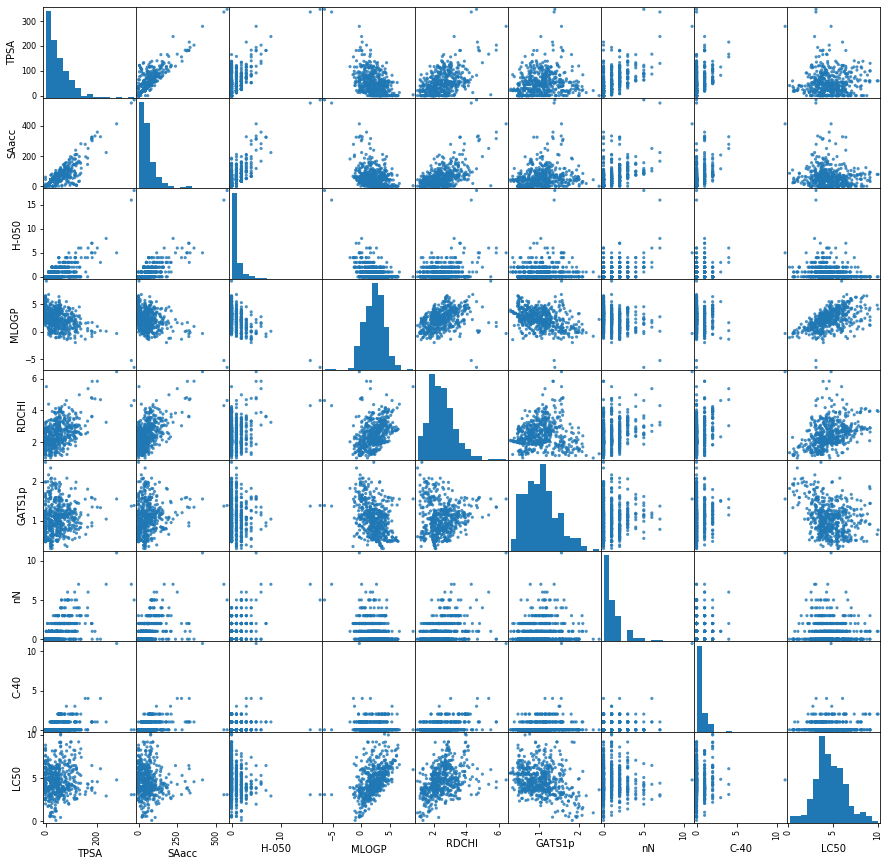

In [8]:
plt.figure(figsize=(10, 10))
for i in range(data.shape[1]):
    plt.subplot(3, 3, i+1)
    plt.plot(data[:, i])
    plt.ylabel(names[i])
plt.tight_layout()

pd.plotting.scatter_matrix(datadf, figsize=(15, 15), marker = 'o', hist_kwds = {'bins': 15}, s = 10, alpha = 0.8);

In [209]:
np.random.shuffle(data)
Xtrain = data[:-46, :-1]
Ttrain = data[:-46, -1:]
Xtest = data[-46:, :-1]
Ttest = data[-46:, -1:]
Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape

((500, 8), (500, 1), (46, 8), (46, 1))

In [275]:
def rmse(Y, T):
    error = T - Y
    return np.sqrt(np.mean(error ** 2))

def run(Xtrain, Ttrain, Xtest, Ttest,n_hiddens_list,  method, n_epochs, learning_rate=0):

    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]
    nnet = NeuralNetworks(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

    #def rmse(Y, T):
        #error = T - Y
        #return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    plt.figure(1, figsize=(10, 10))
    plt.clf()

    n_plot_rows = nnet.n_layers + 1
    pi = 0

    pi=pi+1
    plt.subplot(n_plot_rows, 1, pi)
    plt.plot(nnet.get_error_trace())
    plt.title('Epoch vs RMSE')  
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.grid(True)   
   
       
    plt.figure(figsize=(12, 6))
    plt.plot(Ttrain, 'o')
    plt.title('Sample Index vs Toxicity')
    plt.xlabel('Sample Index')
    plt.ylabel('Toxicity')
    plt.grid(True)   
    Y = nnet.use(Xtrain)
    plt.plot(Y)
    plt.xlim(0,500)
   
    plt.figure(figsize=(12, 6))
    plt.plot(Ttest, 'o')
    plt.title('Sample Index vs Toxicity')
    plt.xlabel('Sample Index')
    plt.ylabel('Toxicity')
    plt.grid(True)   
    Y = nnet.use(Xtest)
    plt.plot(Y)

## n_hidden_list = [10,10,2,10,10]  

Adam: Epoch 200 Error=0.82897
Adam: Epoch 400 Error=0.70797
Adam: Epoch 600 Error=0.65176
Adam: Epoch 800 Error=0.62500
Adam: Epoch 1000 Error=0.62537
Adam: Epoch 1200 Error=0.58338
Adam: Epoch 1400 Error=0.58285
Adam: Epoch 1600 Error=0.54431
Adam: Epoch 1800 Error=0.53550
Adam: Epoch 2000 Error=0.52374
Method: adam, RMSE: Train 0.52 Test 1.65


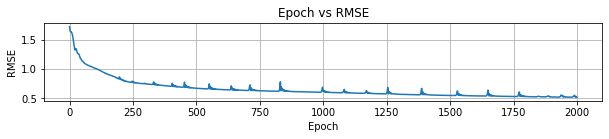

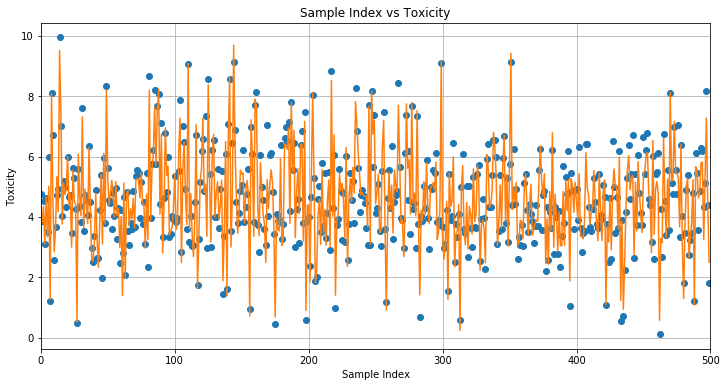

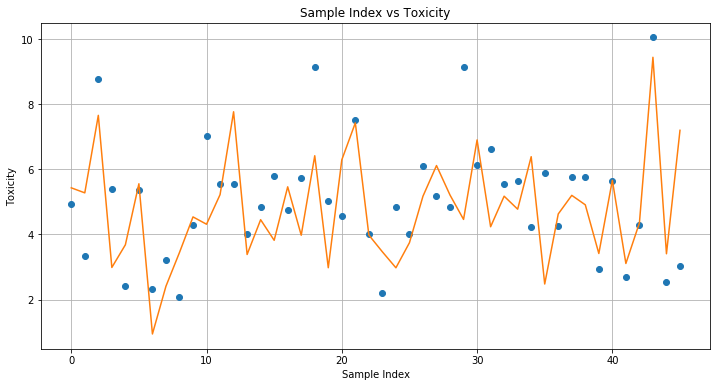

In [240]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"adam", 2000, 0.01)

Adam: Epoch 400 Error=0.76277
Adam: Epoch 800 Error=0.64559
Adam: Epoch 1200 Error=0.57833
Adam: Epoch 1600 Error=0.54816
Adam: Epoch 2000 Error=0.51765
Adam: Epoch 2400 Error=0.50577
Adam: Epoch 2800 Error=0.49026
Adam: Epoch 3200 Error=0.48290
Adam: Epoch 3600 Error=0.47371
Adam: Epoch 4000 Error=0.46561
Method: adam, RMSE: Train 0.47 Test 1.72


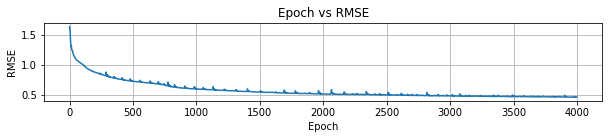

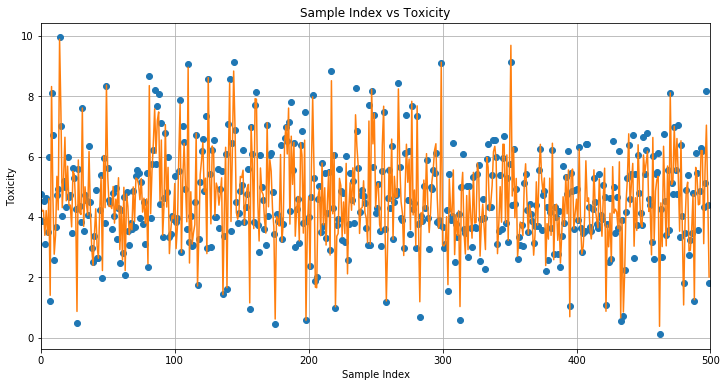

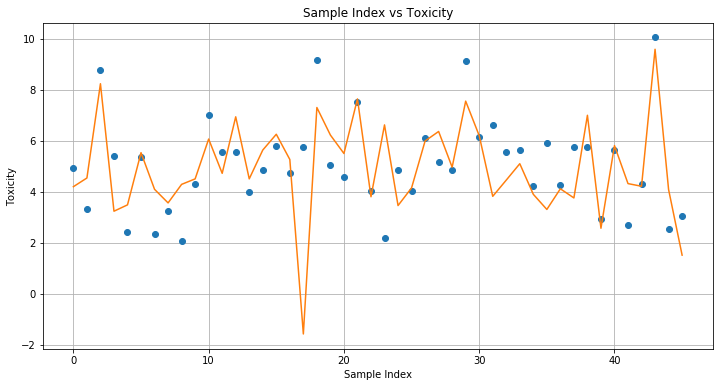

In [241]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"adam", 4000, 0.01)

Adam: Epoch 200 Error=0.69473
Adam: Epoch 400 Error=0.58103
Adam: Epoch 600 Error=0.54081
Adam: Epoch 800 Error=0.52069
Adam: Epoch 1000 Error=0.48080
Adam: Epoch 1200 Error=0.48131
Adam: Epoch 1400 Error=0.46636
Adam: Epoch 1600 Error=0.50602
Adam: Epoch 1800 Error=0.45396
Adam: Epoch 2000 Error=0.41266
Method: adam, RMSE: Train 0.41 Test 1.40


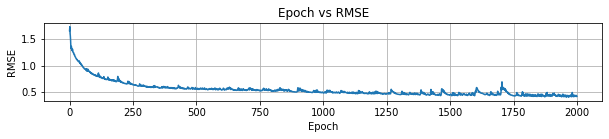

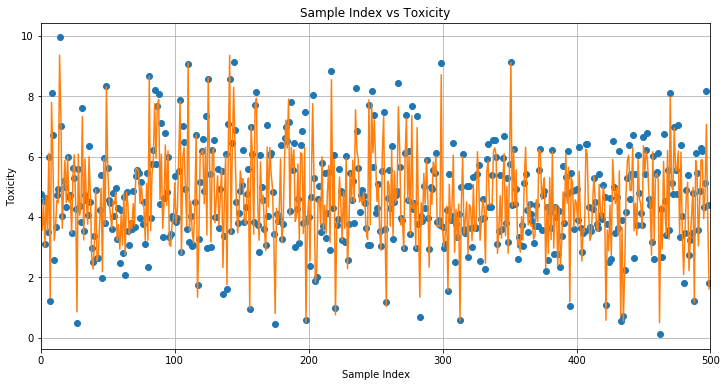

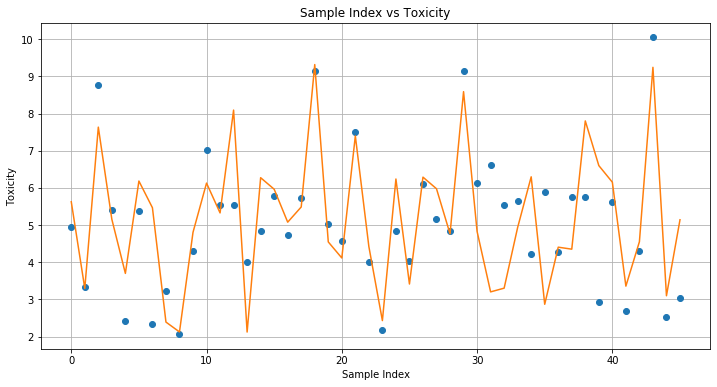

In [282]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"adam", 2000, 0.05)

Adam: Epoch 400 Error=0.59208
Adam: Epoch 800 Error=0.50698
Adam: Epoch 1200 Error=0.49035
Adam: Epoch 1600 Error=0.43608
Adam: Epoch 2000 Error=0.46035
Adam: Epoch 2400 Error=0.40007
Adam: Epoch 2800 Error=0.42534
Adam: Epoch 3200 Error=0.40967
Adam: Epoch 3600 Error=0.40425
Adam: Epoch 4000 Error=0.39101
Method: adam, RMSE: Train 0.38 Test 1.63


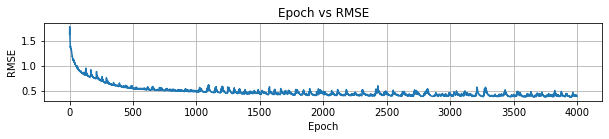

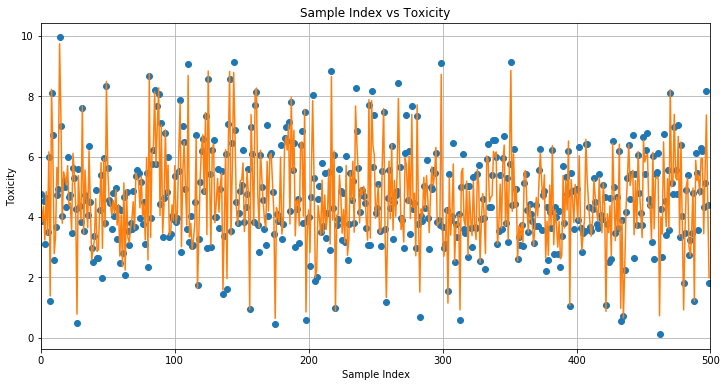

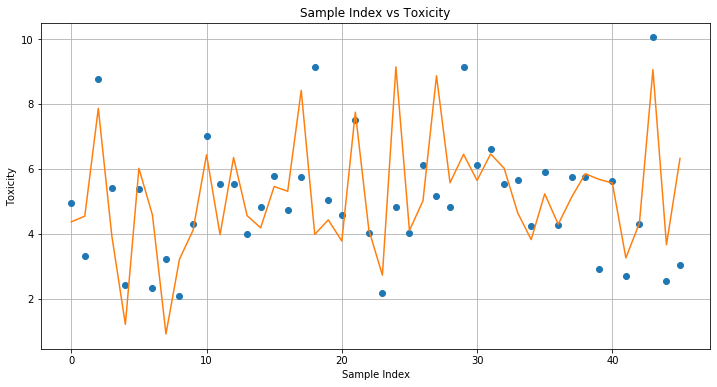

In [283]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"adam", 4000, 0.05)

sgd: Epoch 200 Error=1.63689
sgd: Epoch 400 Error=1.62414
sgd: Epoch 600 Error=1.53122
sgd: Epoch 800 Error=1.29501
sgd: Epoch 1000 Error=1.24775
sgd: Epoch 1200 Error=1.21352
sgd: Epoch 1400 Error=1.18497
sgd: Epoch 1600 Error=1.16408
sgd: Epoch 1800 Error=1.15369
sgd: Epoch 2000 Error=1.14793
Method: sgd, RMSE: Train 1.15 Test 1.40


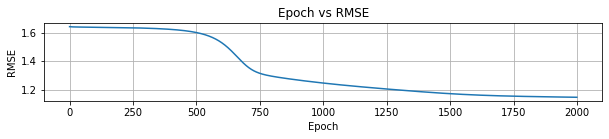

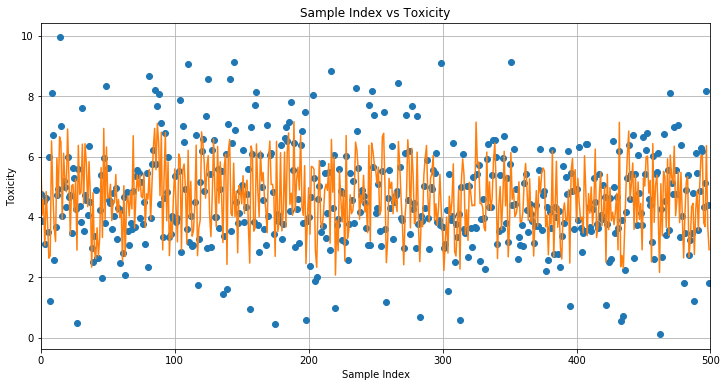

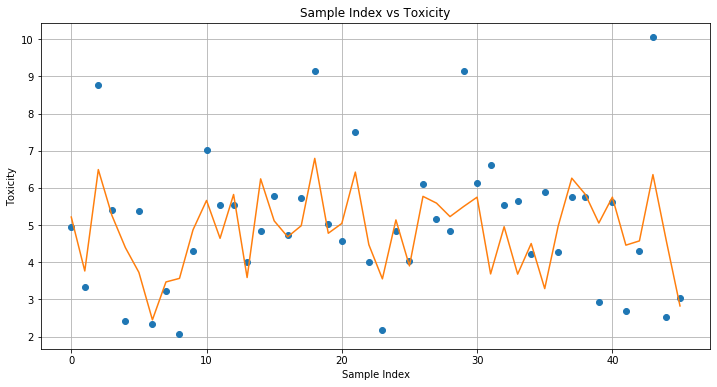

In [243]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"sgd", 2000, 0.01)

sgd: Epoch 400 Error=1.31065
sgd: Epoch 800 Error=1.18614
sgd: Epoch 1200 Error=1.14220
sgd: Epoch 1600 Error=1.12689
sgd: Epoch 2000 Error=1.11379
sgd: Epoch 2400 Error=1.09754
sgd: Epoch 2800 Error=1.07601
sgd: Epoch 3200 Error=1.05575
sgd: Epoch 3600 Error=1.03646
sgd: Epoch 4000 Error=1.01708
Method: sgd, RMSE: Train 1.02 Test 1.26


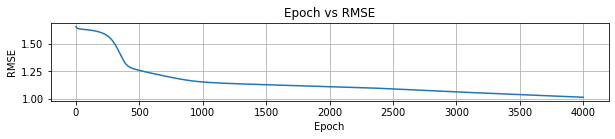

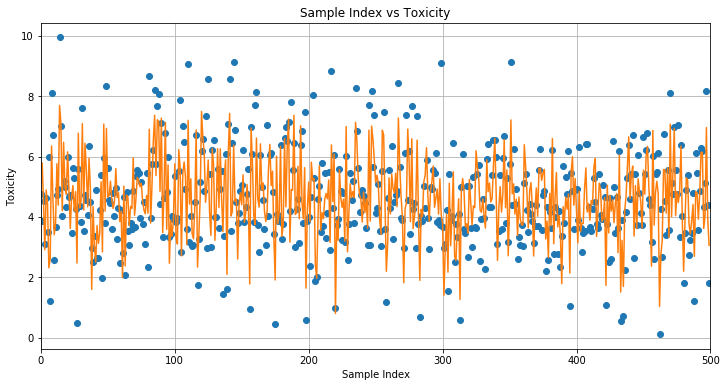

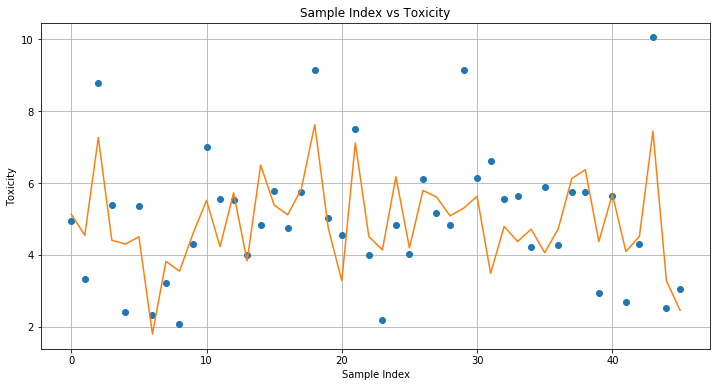

In [244]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"sgd", 4000, 0.01)

sgd: Epoch 200 Error=1.18260
sgd: Epoch 400 Error=1.09905
sgd: Epoch 600 Error=1.08942
sgd: Epoch 800 Error=1.07134
sgd: Epoch 1000 Error=1.04669
sgd: Epoch 1200 Error=1.02774
sgd: Epoch 1400 Error=1.01052
sgd: Epoch 1600 Error=0.99627
sgd: Epoch 1800 Error=0.98518
sgd: Epoch 2000 Error=0.97531
Method: sgd, RMSE: Train 0.97 Test 1.14


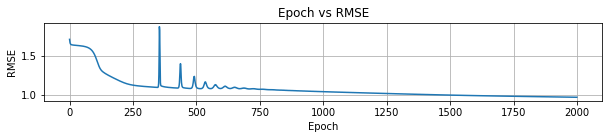

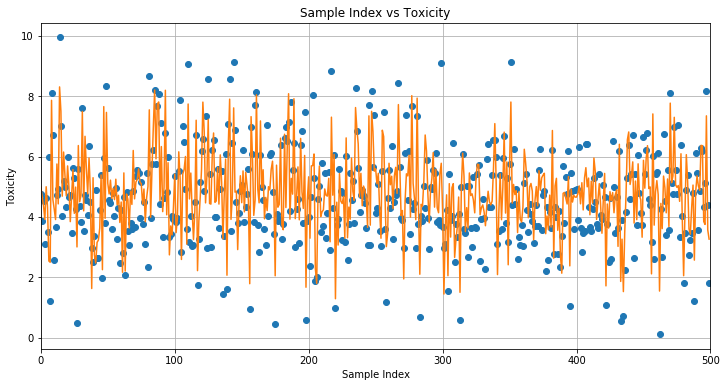

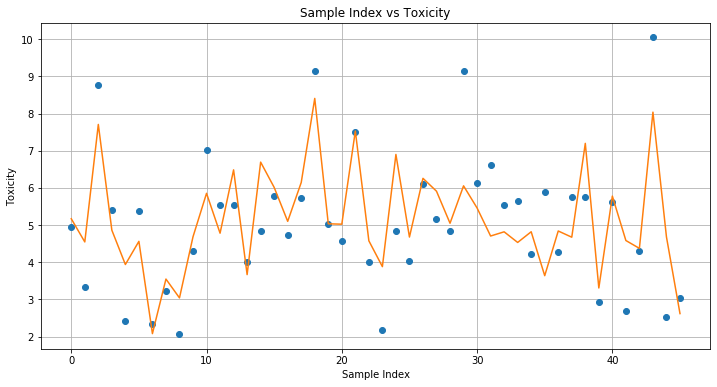

In [284]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"sgd", 2000, 0.05)

sgd: Epoch 400 Error=1.10396
sgd: Epoch 800 Error=1.08158
sgd: Epoch 1200 Error=1.05215
sgd: Epoch 1600 Error=0.99846
sgd: Epoch 2000 Error=0.96377
sgd: Epoch 2400 Error=0.93920
sgd: Epoch 2800 Error=0.91597
sgd: Epoch 3200 Error=0.89246
sgd: Epoch 3600 Error=0.86867
sgd: Epoch 4000 Error=0.84383
Method: sgd, RMSE: Train 0.84 Test 1.34


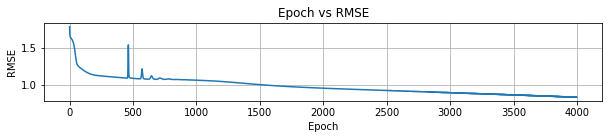

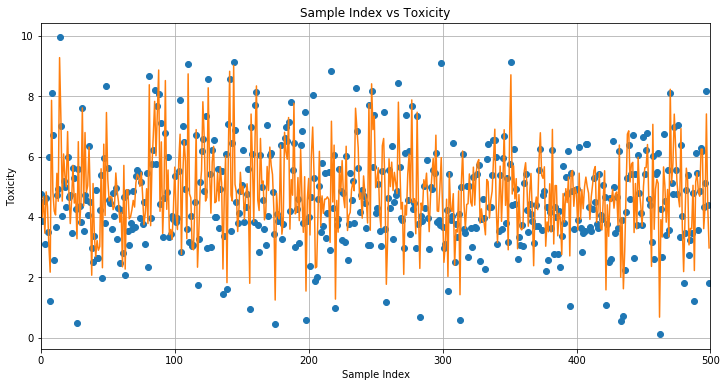

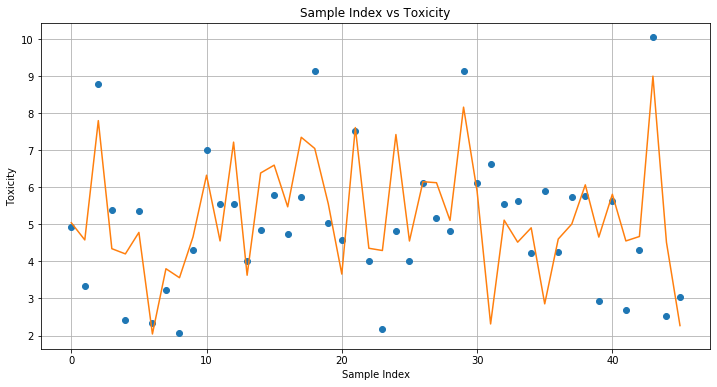

In [285]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"sgd", 4000, 0.05)

SCG: Epoch 199 Error=0.90951
SCG: Epoch 399 Error=0.68808
SCG: Epoch 599 Error=0.59131
SCG: Epoch 799 Error=0.50825
SCG: Epoch 999 Error=0.46711
SCG: Epoch 1199 Error=0.43497
SCG: Epoch 1399 Error=0.41428
SCG: Epoch 1599 Error=0.40075
SCG: Epoch 1799 Error=0.39594
SCG: Epoch 1999 Error=0.39268
Method: scg, RMSE: Train 0.39 Test 2.20


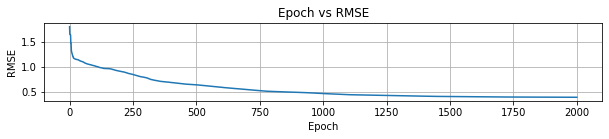

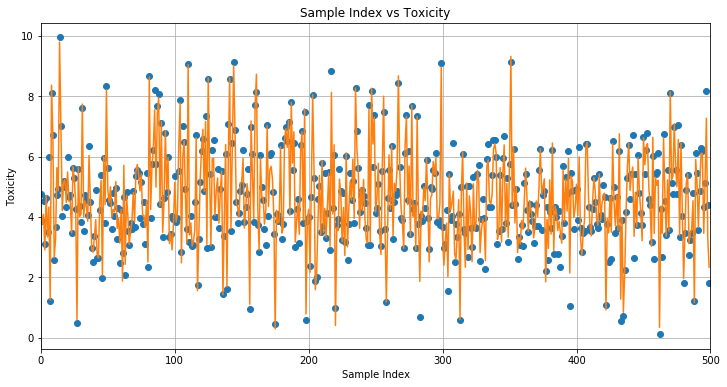

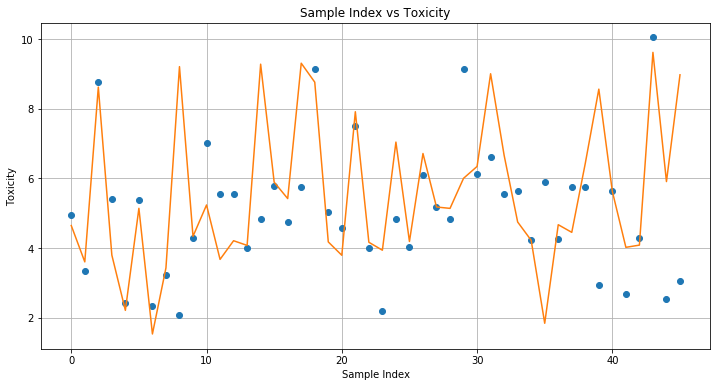

In [246]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"scg", 2000)

SCG: Epoch 399 Error=0.67280
SCG: Epoch 799 Error=0.53300
SCG: Epoch 1199 Error=0.45467
SCG: Epoch 1599 Error=0.42201
SCG: Epoch 1999 Error=0.41008
SCG: Epoch 2399 Error=0.40030
SCG: Epoch 2799 Error=0.39403
SCG: Epoch 3199 Error=0.38939
SCG: Epoch 3599 Error=0.38699
SCG: Epoch 3999 Error=0.38409
Method: scg, RMSE: Train 0.38 Test 1.41


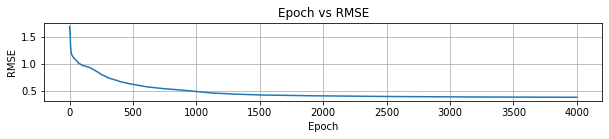

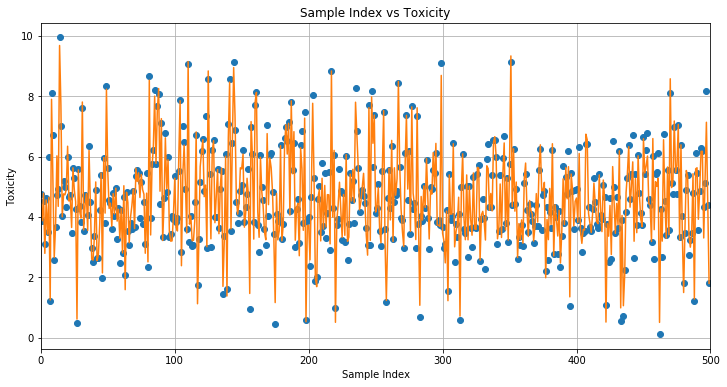

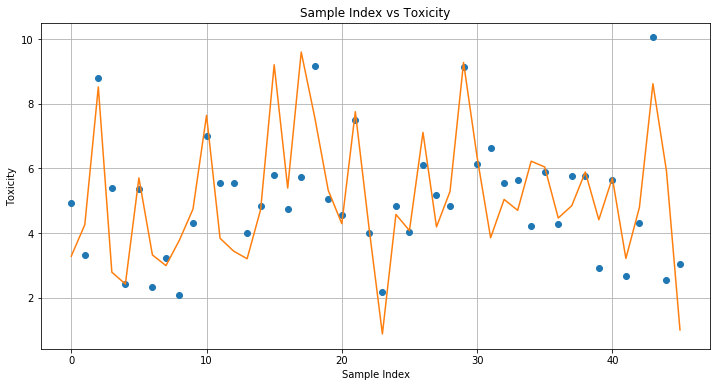

In [247]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"scg", 4000)

SCG: Epoch 599 Error=0.61128
SCG: Epoch 1199 Error=0.53560
SCG: Epoch 1799 Error=0.49057
SCG: Epoch 2399 Error=0.45578
SCG: Epoch 2999 Error=0.43680
SCG: Epoch 3599 Error=0.43013
SCG: Epoch 4199 Error=0.42324
SCG: Epoch 4799 Error=0.41794
SCG: Epoch 5399 Error=0.41378
SCG: Epoch 5999 Error=0.41038
Method: scg, RMSE: Train 0.41 Test 2.02


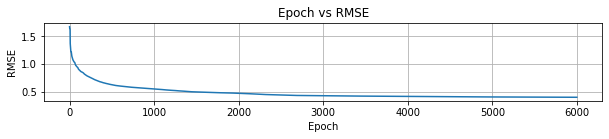

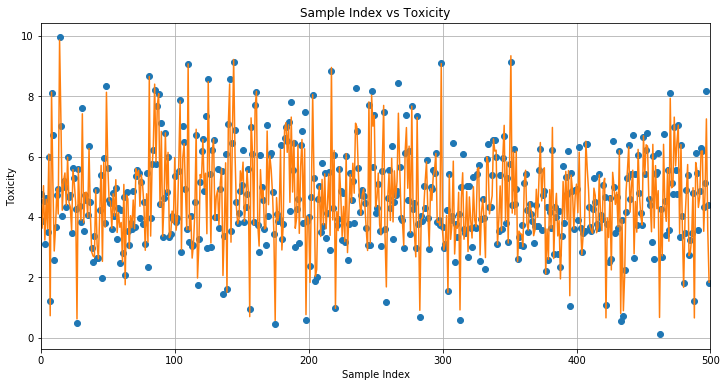

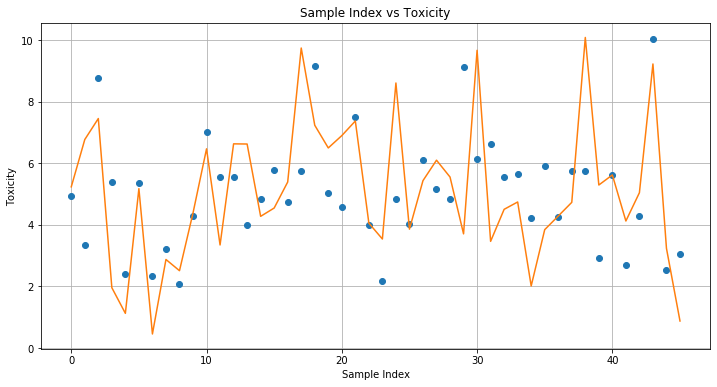

In [248]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,10,2,10,10],"scg", 6000)

# n_hidden_list = [10,50,10]  

Adam: Epoch 200 Error=0.78300
Adam: Epoch 400 Error=0.43847
Adam: Epoch 600 Error=0.33985
Adam: Epoch 800 Error=0.27163
Adam: Epoch 1000 Error=0.23087
Adam: Epoch 1200 Error=0.20956
Adam: Epoch 1400 Error=0.19548
Adam: Epoch 1600 Error=0.18605
Adam: Epoch 1800 Error=0.17883
Adam: Epoch 2000 Error=0.17259
Method: adam, RMSE: Train 0.17 Test 1.59


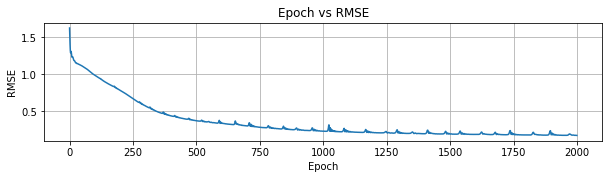

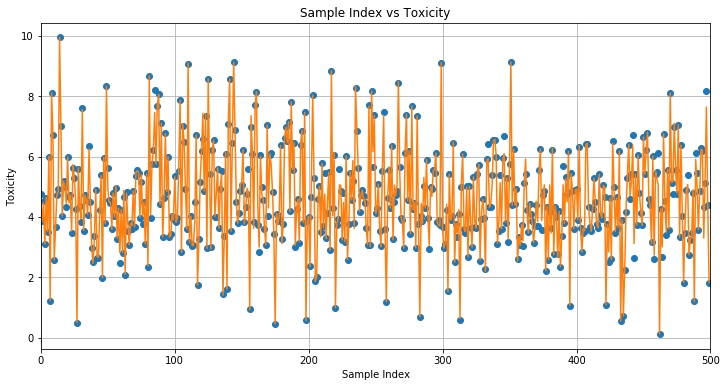

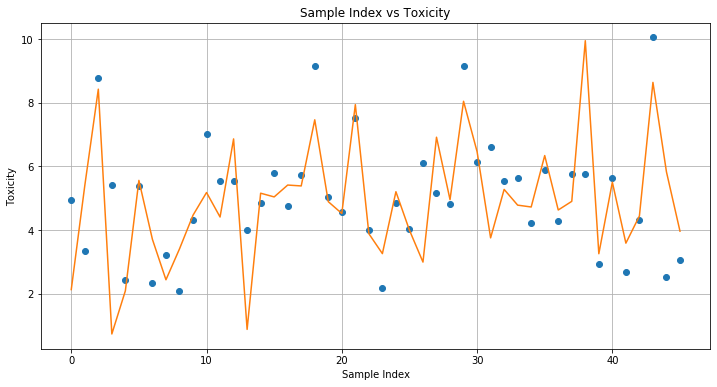

In [286]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"adam", 2000, 0.01)

Adam: Epoch 400 Error=0.53332
Adam: Epoch 800 Error=0.40006
Adam: Epoch 1200 Error=0.29697
Adam: Epoch 1600 Error=0.27992
Adam: Epoch 2000 Error=0.18913
Adam: Epoch 2400 Error=0.18069
Adam: Epoch 2800 Error=0.24328
Adam: Epoch 3200 Error=0.14490
Adam: Epoch 3600 Error=0.16175
Adam: Epoch 4000 Error=0.13417
Method: adam, RMSE: Train 0.13 Test 2.17


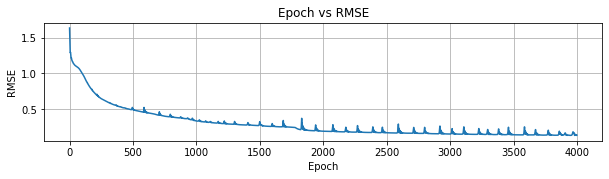

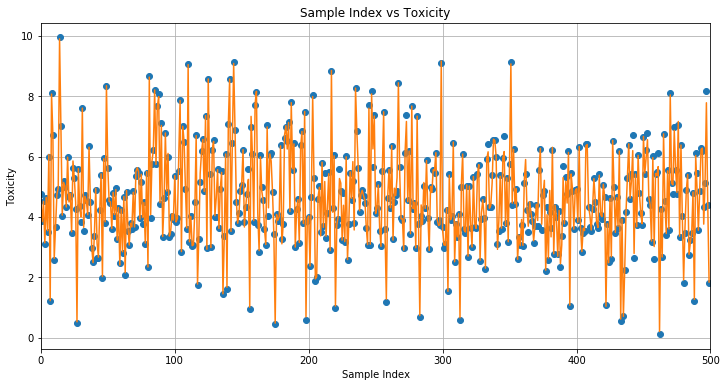

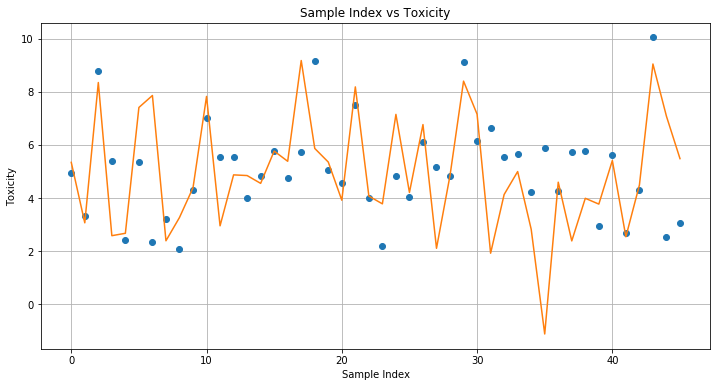

In [288]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"adam", 4000, 0.01)

Adam: Epoch 200 Error=0.51988
Adam: Epoch 400 Error=0.32867
Adam: Epoch 600 Error=0.38248
Adam: Epoch 800 Error=0.30165
Adam: Epoch 1000 Error=0.23780
Adam: Epoch 1200 Error=0.22937
Adam: Epoch 1400 Error=0.21193
Adam: Epoch 1600 Error=0.20465
Adam: Epoch 1800 Error=0.19227
Adam: Epoch 2000 Error=0.20073
Method: adam, RMSE: Train 0.21 Test 1.50


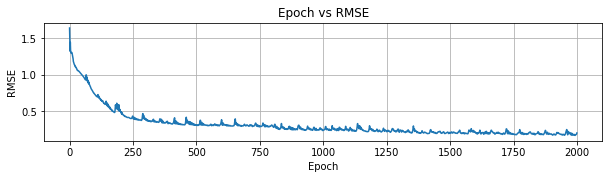

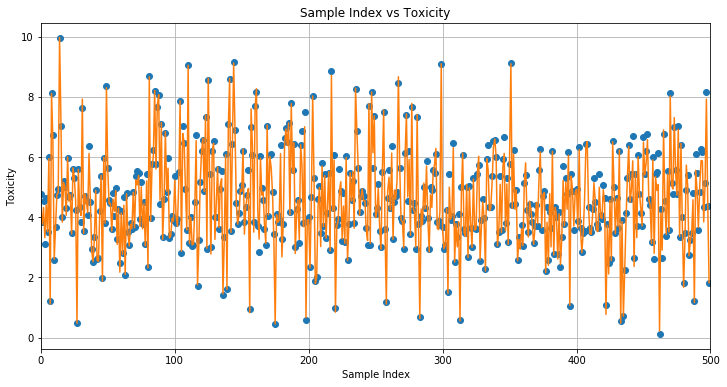

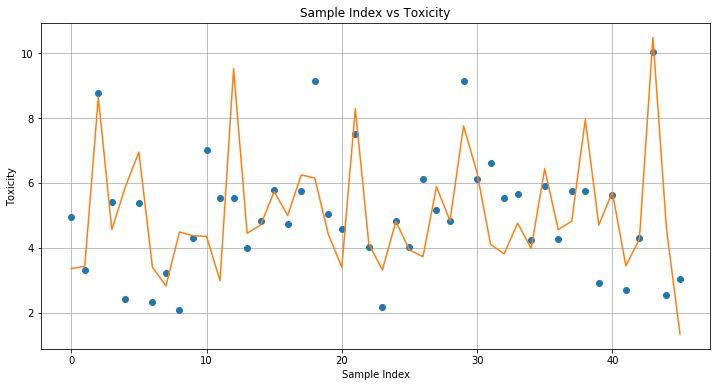

In [289]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"adam", 2000, 0.05)

Adam: Epoch 400 Error=0.31225
Adam: Epoch 800 Error=0.25065
Adam: Epoch 1200 Error=0.25114
Adam: Epoch 1600 Error=0.21679
Adam: Epoch 2000 Error=0.21183
Adam: Epoch 2400 Error=0.24563
Adam: Epoch 2800 Error=0.15094
Adam: Epoch 3200 Error=0.12925
Adam: Epoch 3600 Error=0.14621
Adam: Epoch 4000 Error=0.13179
Method: adam, RMSE: Train 0.14 Test 1.53


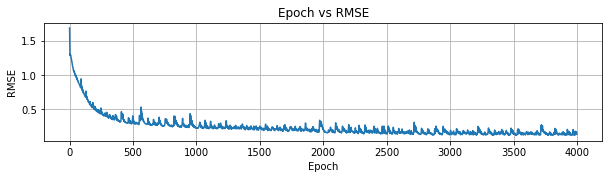

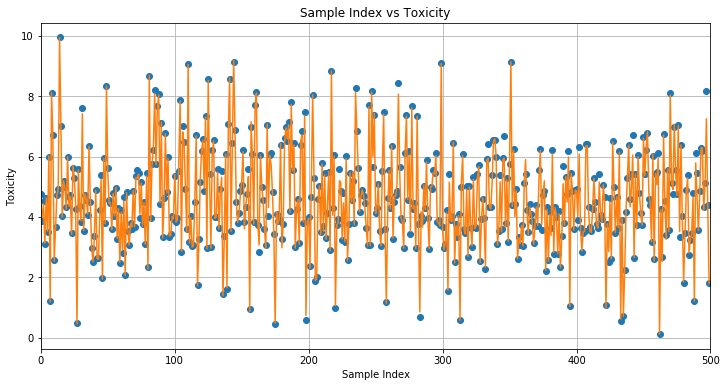

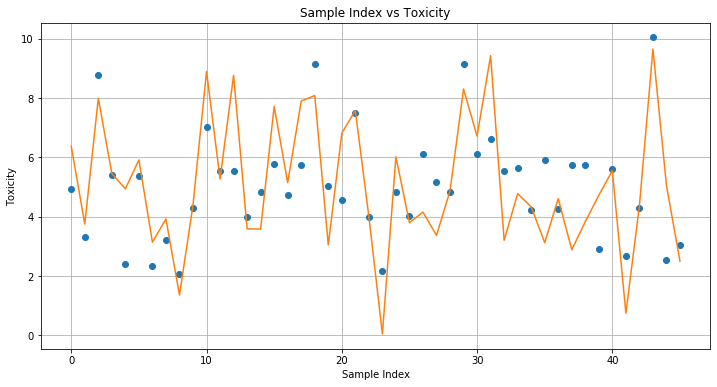

In [290]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"adam", 4000, 0.05)

sgd: Epoch 200 Error=1.30434
sgd: Epoch 400 Error=1.22499
sgd: Epoch 600 Error=1.18580
sgd: Epoch 800 Error=1.16057
sgd: Epoch 1000 Error=1.14659
sgd: Epoch 1200 Error=1.13866
sgd: Epoch 1400 Error=1.13268
sgd: Epoch 1600 Error=1.12724
sgd: Epoch 1800 Error=1.12185
sgd: Epoch 2000 Error=1.11638
Method: sgd, RMSE: Train 1.12 Test 1.31


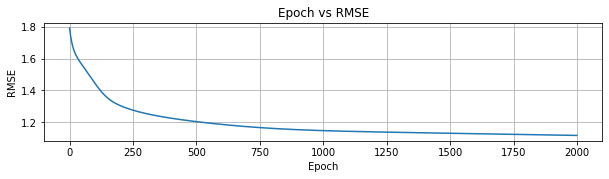

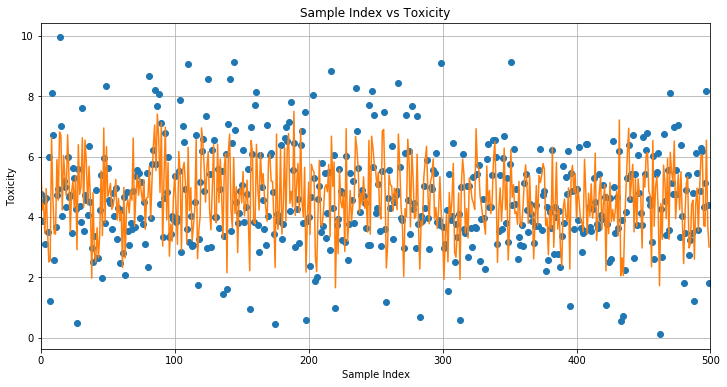

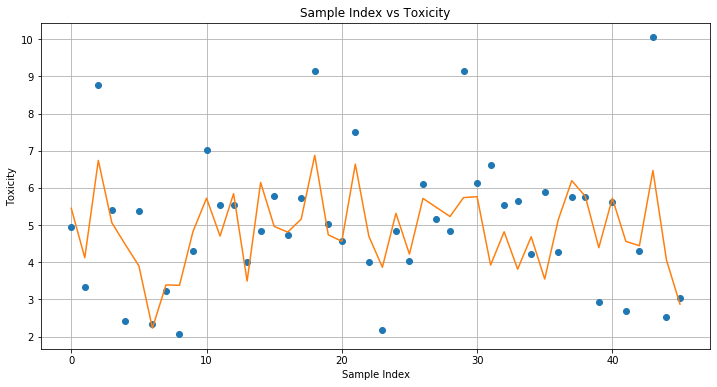

In [291]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"sgd", 2000, 0.01)

sgd: Epoch 400 Error=1.21765
sgd: Epoch 800 Error=1.15976
sgd: Epoch 1200 Error=1.13765
sgd: Epoch 1600 Error=1.12726
sgd: Epoch 2000 Error=1.11607
sgd: Epoch 2400 Error=1.10388
sgd: Epoch 2800 Error=1.09276
sgd: Epoch 3200 Error=1.08304
sgd: Epoch 3600 Error=1.07347
sgd: Epoch 4000 Error=1.06285
Method: sgd, RMSE: Train 1.06 Test 1.17


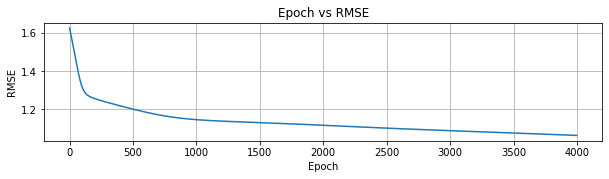

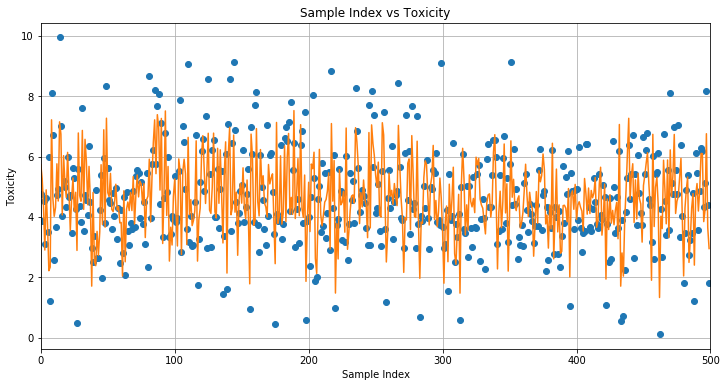

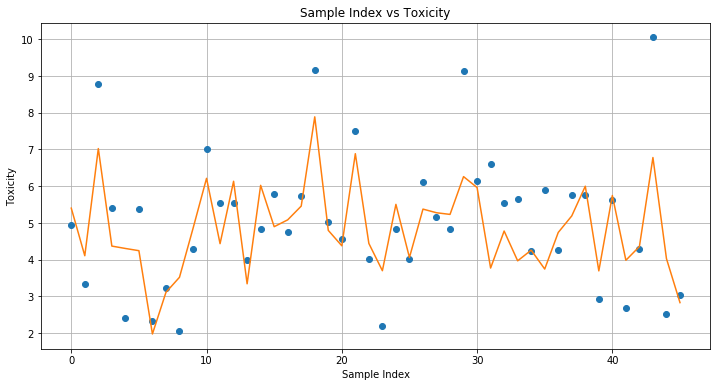

In [292]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"sgd", 4000, 0.01)

sgd: Epoch 200 Error=1.13383
sgd: Epoch 400 Error=1.10802
sgd: Epoch 600 Error=1.08513
sgd: Epoch 800 Error=1.06186
sgd: Epoch 1000 Error=1.03352
sgd: Epoch 1200 Error=1.00279
sgd: Epoch 1400 Error=0.97636
sgd: Epoch 1600 Error=0.99770
sgd: Epoch 1800 Error=0.95065
sgd: Epoch 2000 Error=0.94178
Method: sgd, RMSE: Train 0.94 Test 1.16


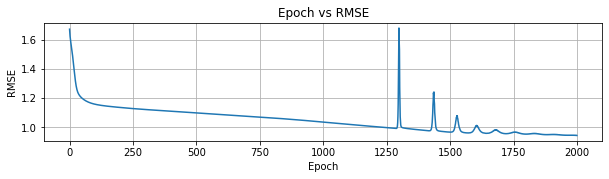

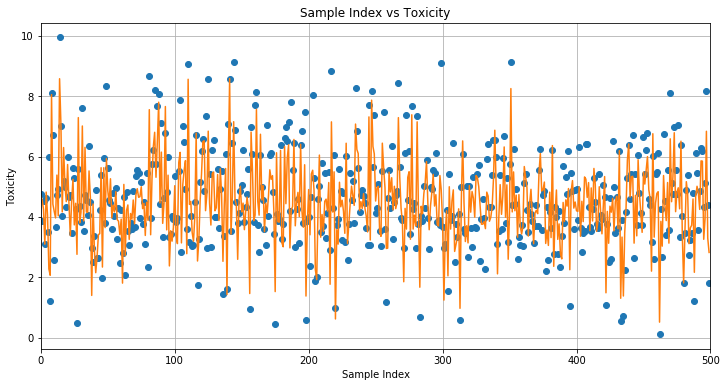

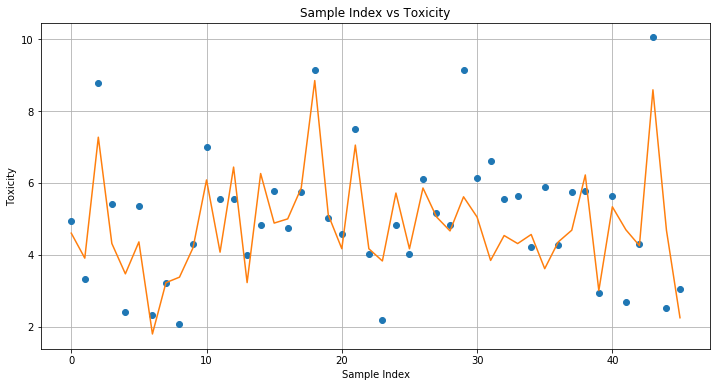

In [293]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"sgd", 2000, 0.05)

sgd: Epoch 400 Error=1.10813
sgd: Epoch 800 Error=1.04753
sgd: Epoch 1200 Error=1.01731
sgd: Epoch 1600 Error=0.99489
sgd: Epoch 2000 Error=0.97453
sgd: Epoch 2400 Error=0.94883
sgd: Epoch 2800 Error=0.91185
sgd: Epoch 3200 Error=0.87829
sgd: Epoch 3600 Error=0.85110
sgd: Epoch 4000 Error=0.82726
Method: sgd, RMSE: Train 0.83 Test 1.25


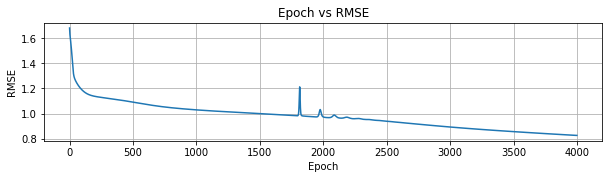

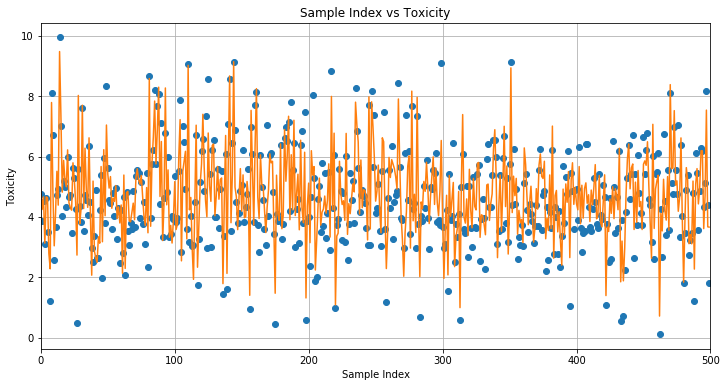

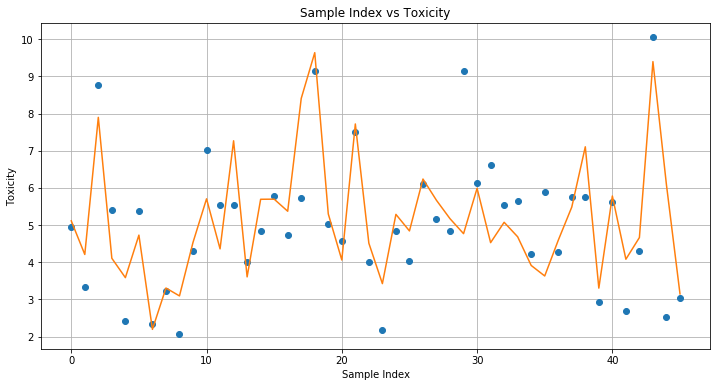

In [294]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"sgd", 4000, 0.05)

SCG: Epoch 199 Error=0.62167
SCG: Epoch 399 Error=0.36457
SCG: Epoch 599 Error=0.24725
SCG: Epoch 799 Error=0.18660
SCG: Epoch 999 Error=0.15714
SCG: Epoch 1199 Error=0.13836
SCG: Epoch 1399 Error=0.12565
SCG: Epoch 1599 Error=0.11361
SCG: Epoch 1799 Error=0.10398
SCG: Epoch 1999 Error=0.09554
Method: scg, RMSE: Train 0.10 Test 2.54


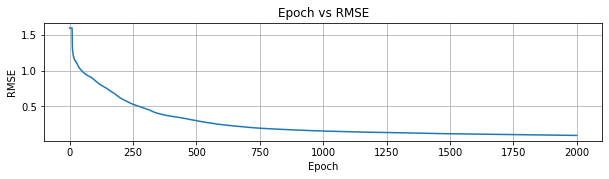

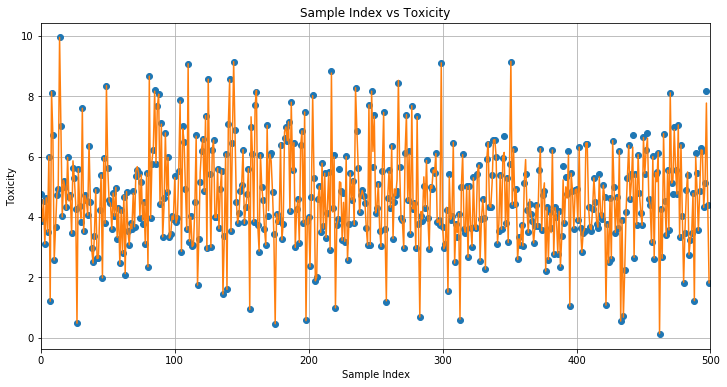

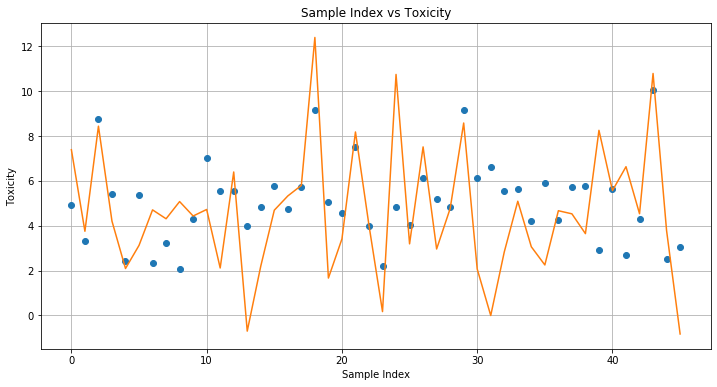

In [295]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"scg", 2000)

SCG: Epoch 399 Error=0.36956
SCG: Epoch 799 Error=0.22808
SCG: Epoch 1199 Error=0.18445
SCG: Epoch 1599 Error=0.15123
SCG: Epoch 1999 Error=0.12557
SCG: Epoch 2399 Error=0.11142
SCG: Epoch 2799 Error=0.10416
SCG: Epoch 3199 Error=0.09569
SCG: Epoch 3599 Error=0.09125
SCG: Epoch 3999 Error=0.08900
Method: scg, RMSE: Train 0.09 Test 3.40


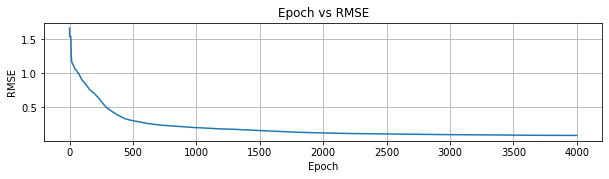

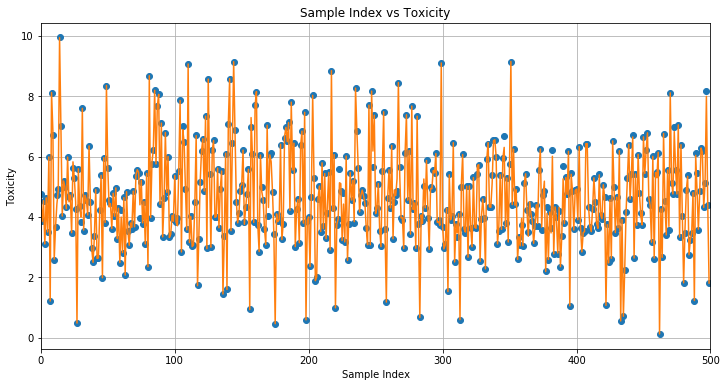

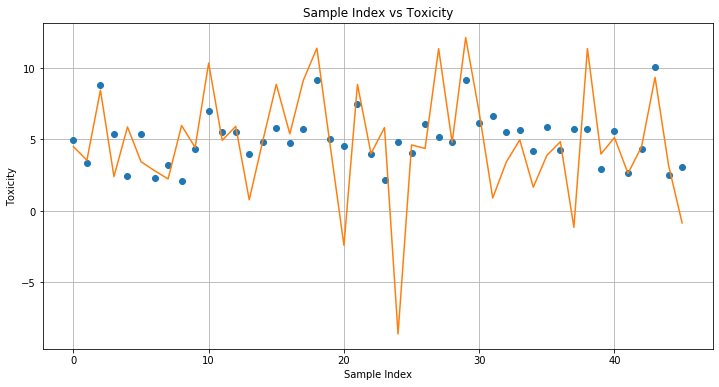

In [296]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"scg", 4000)

SCG: Epoch 599 Error=0.34402
SCG: Epoch 1199 Error=0.23738
SCG: Epoch 1799 Error=0.18165
SCG: Epoch 2399 Error=0.15869
SCG: Epoch 2999 Error=0.13739
SCG: Epoch 3599 Error=0.11691
SCG: Epoch 4199 Error=0.10881
SCG: Epoch 4799 Error=0.10286
SCG: Epoch 5399 Error=0.10002
SCG: Epoch 5999 Error=0.09450
Method: scg, RMSE: Train 0.09 Test 4.32


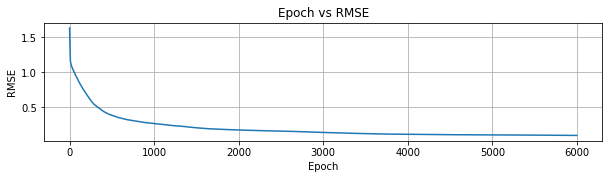

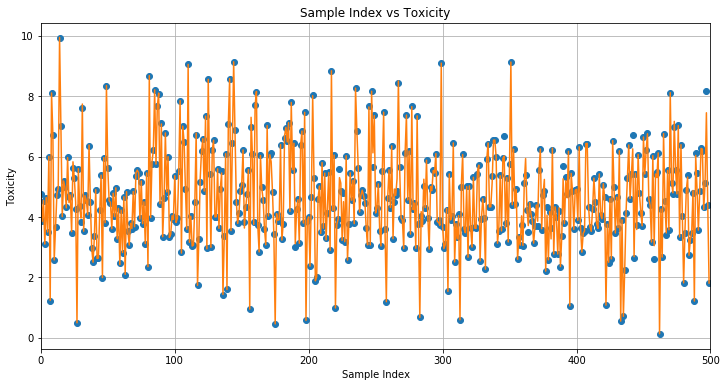

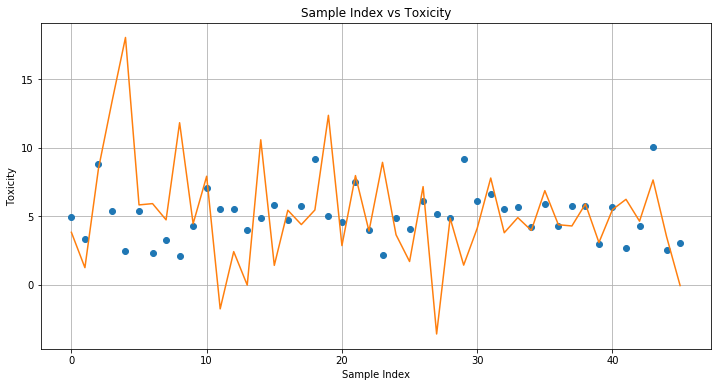

In [297]:
run(Xtrain, Ttrain, Xtest, Ttest,[10,50,10],"scg", 6000)

## n_hidden_list= [10,10,2,10,10]

In [301]:
data = [["ADAM","2000", "0.01","0.52","1.65"], ["ADAM","4000", "0.01","0.47","1.72"],["ADAM","2000","0.05","0.41","1.40"],["ADAM","4000","0.05","0.38","1.63"],["sgd","2000","0.01","1.15","1.4"],["sgd","4000","0.01","1.02","1.26"],["sgd","2000","0.05","0.97","1.14"],["sgd","4000","0.05","0.84","1.34"],["sgc","2000","0","0.39","2.2"],["sgc","4000","0","0.38","1.41"],["sgc","6000","0","0.41","2.02"]]
pd.DataFrame(data, columns=["Method", "n_epochs","Learning Rate","RSME train","RSME test"])

Method n_epochs Learning Rate RSME train RSME test
0    ADAM     2000          0.01       0.52      1.65
1    ADAM     4000          0.01       0.47      1.72
2    ADAM     2000          0.05       0.41      1.40
3    ADAM     4000          0.05       0.38      1.63
4     sgd     2000          0.01       1.15       1.4
5     sgd     4000          0.01       1.02      1.26
6     sgd     2000          0.05       0.97      1.14
7     sgd     4000          0.05       0.84      1.34
8     sgc     2000             0       0.39       2.2
9     sgc     4000             0       0.38      1.41
10    sgc     6000             0       0.41      2.02

## n_hidden_list= [10,50,10]

In [302]:
data1 = [["ADAM","2000", "0.01","0.17","1.59"], ["ADAM","4000", "0.01","0.13","2.17"],["ADAM","2000","0.05","0.21","1.5"],["ADAM","4000","0.05","0.14","1.53"],["sgd","2000","0.01","1.12","1.31"],["sgd","4000","0.01","1.06","1.17"],["sgd","2000","0.05","0.94","1.16"],["sgd","4000","0.05","0.83","1.25"],["sgc","2000","0","0.1","2.54"],["sgc","4000","0","0.09","3.4"],["sgc","6000","0","0.09","4.62"]]
pd.DataFrame(data1, columns=["Method", "n_epochs","Learning Rate","RSME train","RSME test"])

Method n_epochs Learning Rate RSME train RSME test
0    ADAM     2000          0.01       0.17      1.59
1    ADAM     4000          0.01       0.13      2.17
2    ADAM     2000          0.05       0.21       1.5
3    ADAM     4000          0.05       0.14      1.53
4     sgd     2000          0.01       1.12      1.31
5     sgd     4000          0.01       1.06      1.17
6     sgd     2000          0.05       0.94      1.16
7     sgd     4000          0.05       0.83      1.25
8     sgc     2000             0        0.1      2.54
9     sgc     4000             0       0.09       3.4
10    sgc     6000             0       0.09      4.62

# Result

1. Gradient Descent minimizes the cost function(RMSE) by performing forward and backward propagation for change weights of the neurons. That is why error value reduces to a near zero at certain epoch based on the hidden layer.
2. The aim with this test is to compare the performance of various gradient descent.
3. Gradient descent is considered as the preferred way to optimize neural networks and many other machine learning algorithms. 
4. In this assignment ,we have utilized three Gradient descent: Adam, SGD and SCG. Adam(Adaptive Moment Estimation) is a method that computes adaptive learning rates for each parameter.SGD(Stochastic Gradient Descent) is an iterative method for optimizing an objective function with suitable smoothness properties  where it can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient by an estimate thereof. SCG(Scaled Conjugate Gradient) is based on conjugate directions, but this algorithm does not perform a line search at each iteration unlike other conjugate gradient algorithms which require a line search at each iteration. 
5. As the number of hidden list increases, the testing data tend to satisfy less due to which more hidden layer will over fit the data and lesser hidden layer will under fit the data ,irrespective of the optimization algorithms.
6. Once they are trained, the predictions are pretty fast.
7. In the case of ADAM, the cost function is decreasing as the number of epochs value increases, keeping the leraning rate to be constant. As the iterations are moving, the error value for the train to be decreasing and testing value to be increasing. Thus,from the graph we can infer that the best fit would be possible for less number of epochs with low learning rate. 
8. Similar to ADAM,SGD seem to show RMSE value decreasing as the number of epochs value increases.As the iterations are moving, the error value for the train to be decreasing and testing value to be increasing. Thus,from the graph we can infer that the best fit would be possible for less number of epochs with low learning rate. 
9. In the case of SCG, lower number of epochs tend to provide better fit as it does not require any learning rate. Thus, the number of epoch is inversely proportional to the fitted value, thus it is preferable to have a lower number of epoch in order to have the best fit.If the iteration has converged, or if too many iterations have been done,would make your model converge slower. Hence, SCG tend to be provide faster coverage.    
10. From the graphs,We can confidently say that an important parameter in gradient descent is learning rate, which determine the size of each step. When learning rate is too big, gradient descent may jump across the valley and end up on the other side,thus leads to the cost function diverge.
 

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 40 points will be based on other testing and the results you obtain and your discussions. 

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A3.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [252]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'ESWARAN-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    nnet = NeuralNetwork(2, [5, 4], 3)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    nnet.Ws[0][2, 0] = 100.0
    # Does nnet.Ws[0][2, 0] == nnet.all_weights[10]


--- 10/10 points. nnet.Ws[0][2, 0] equals nnet.all_weights[10]

## Testing constructor #########################################

# Check-In

Do not include this section in your notebook.

Name your notebook ```Lastname-A3.ipynb```.  So, for me it would be ```Anderson-A3.ipynb```.  Submit the file using the ```Assignment 3``` link on [Canvas](https://colostate.instructure.com/courses/109894).